<a href="https://colab.research.google.com/github/warenya/TrajectoryPrediction/blob/main/drone_trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install clifford

In [ ]:
!pip install numba==0.58.1

In [ ]:
!pip install cliffordlayers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import clifford as cf
import scipy as e
from scipy import linalg
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from clifford import Cl
from cliffordlayers.nn.modules.groupnorm import CliffordGroupNorm1d
from cliffordlayers.nn.modules.cliffordconv import _CliffordConvNd
from cliffordlayers.nn.modules.batchnorm import _CliffordBatchNorm
from cliffordlayers.nn.modules.cliffordlinear import CliffordLinear
from cliffordlayers import signature
import pandas as pd

In [ ]:
# Define the geometric algebra parameters for Cl(3, 0, 1)
layout, blades = Cl(2, 0, 1)
num_blades = len(layout.blades_list)
g = [1, 1, 1]  # Signature for Cl(2, 0, 1)

# Create blade mappings
blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->ojk', w, M)  # [out_features, num_blades, num_blades]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,kji->ojk', w, M)  # [out_features, num_blades, num_blades]

class MultiVectorEmbedding:
    def __init__(self, layout):
        self.layout = layout
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}
        self.idx_to_blade_tuple = {i: blade_tuples[i] for i in range(len(blade_tuples))}

    def encode(self, x):
        batch_size = x.shape[0]
        num_features = x.shape[1]  # Should be input_seq_len * 3
        components = torch.zeros(batch_size, num_blades, device=x.device)

        # Map features to blades
        # Adjust the mapping to handle multiple time steps
        for i in range(num_features):
            feature = x[:, i]
            blade_idx = self.blade_tuple_to_idx[self.get_blade_tuple(i)]
            components[:, blade_idx] = feature

        # Optionally set the scalar component
        scalar_idx = self.blade_tuple_to_idx[()]
        components[:, scalar_idx] = 1.0

        return components

    def get_blade_tuple(self, feature_idx):
        # Define how features map to blades
        # For example, use different blades for different time steps
        if feature_idx % 3 == 0:
            return (1,)  # x-component
        elif feature_idx % 3 == 1:
            return (2,)  # y-component
        else:
            return (3,)  # z-component

    def extract_output(self, mv):
        batch_size = mv.size(0)
        e1_idx = self.blade_tuple_to_idx[(1,)]
        e2_idx = self.blade_tuple_to_idx[(2,)]
        e3_idx = self.blade_tuple_to_idx[(3,)]
        output = mv[:, :, [e1_idx, e2_idx, e3_idx]]  # Shape: [batch_size, out_channels, 3]

        # Reshape to [batch_size, pred_seq_len, 3]
        output = output.view(batch_size, -1, 3)
        return output

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)
        # Create the mapping from blade tuples to indices
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}

    def reverse(self, mv):
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(num_blades)],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, num_blades, device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., int(blade_idx)] = tensor[..., idx]
        return mv_tensor

    def norm(self, mv):
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=None,
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra

        if action_blades is None:
            # Use vector blades (grade-1 blades)
            action_blades = [
                self.algebra.blade_tuple_to_idx[(1,)],
                self.algebra.blade_tuple_to_idx[(2,)],
                self.algebra.blade_tuple_to_idx[(3,)]
            ]
            e0_idx = self.algebra.blade_tuple_to_idx.get(('e0',), None)
            if e0_idx is not None:
                action_blades.append(e0_idx)
            self.action_blades = [int(idx) for idx in action_blades]
        else:
            self.action_blades = [int(idx) for idx in action_blades]

        self.n_action_blades = len(self.action_blades)

        # Parameters
        self._action = nn.Parameter(torch.empty(out_features, self.n_action_blades))  # [out_features, n_action_blades]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features, in_features]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features, num_blades]
        norm = self.algebra.norm(action_mv)  # [out_features]

        epsilon = 1e-6
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features, n_action_blades]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features, num_blades]

    def forward(self, input):
        # input: [batch_size, in_channels, num_blades]
        batch_size, in_channels, num_blades = input.shape
        M = self.algebra.cayley.to(input.device)  # [num_blades, num_blades, num_blades]
        k = self.action.to(input.device)  # [out_features, num_blades]
        k_ = self.inverse(k)  # [out_features, num_blades]

        # Compute k_l and k_r
        k_l = get_clifford_left_kernel(M, k)  # [out_features, num_blades, num_blades]
        k_r = get_clifford_right_kernel(M, k_)  # [out_features, num_blades, num_blades]

        # Reshape k_l and k_r for batch computation
        k_l = k_l.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)
        k_r = k_r.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)

        # Reshape x for batch computation
        x = input.view(batch_size * in_channels, 1, num_blades)  # [batch_size*in_channels, 1, num_blades]

        # Apply geometric transformations
        x = torch.einsum('bij,bijk->bik', x, k_l)  # Left multiplication
        x = torch.einsum('bij,bijk->bik', x, k_r)  # Right multiplication

        # x now has shape [batch_size * in_channels, out_channels, num_blades]
        x = x.view(batch_size, in_channels, self.out_features, num_blades)

        # Apply weights
        weight = self.weight.t().unsqueeze(0).unsqueeze(-1)  # [1, in_channels, out_features, 1]
        x = x * weight  # Element-wise multiplication

        # Sum over in_channels
        x = x.sum(dim=1)  # [batch_size, out_features, num_blades]

        return x

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        self.agg = agg

    def forward(self, input):
        if self.agg == "linear":
            activation = torch.sigmoid(input)
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(nn.Module):
    def __init__(self, num_features, num_blades):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features * num_blades)

    def forward(self, x):
        batch_size, channels, num_blades = x.shape
        x_flat = x.view(batch_size, channels * num_blades)
        x_norm = self.bn(x_flat)
        x_norm = x_norm.view(batch_size, channels, num_blades)
        return x_norm

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, num_blades)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=32, num_layers=2):
        super().__init__()
        self.algebra = CliffordAlgebra(layout)
        layers = []
        in_channels = num_blades  # Starting with input blades (16)
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = 1 # Final output layer
            else:
                out_channels = hidden_dim
            layers.append(GCALayer(in_channels, out_channels, self.algebra))
            in_channels = out_channels
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def forward(self, x):
        # x now has shape [batch_size, input_seq_len * 3]
        x = x.view(x.size(0), -1)  # Flatten if not already
        x = self.embedding.encode(x)
        x = x.to(self.device)
        x = x.unsqueeze(1)  # Add channels dimension: [batch_size, 1, num_blades]
        for layer in self.layers:
            x = layer(x)
        output = self.embedding.extract_output(x)
        return output

Train dataset length: 2430
Test dataset length: 270
Epoch [2/100], Loss: 1.2328
Epoch [12/100], Loss: 0.4156
Epoch [22/100], Loss: 0.4067
Epoch [32/100], Loss: 0.3873
Epoch [42/100], Loss: 0.4073
Epoch [52/100], Loss: 0.3964
Epoch [62/100], Loss: 0.3940
Epoch [72/100], Loss: 0.3978
Epoch [82/100], Loss: 0.4061
Epoch [92/100], Loss: 0.3991
Test Loss: 0.1513


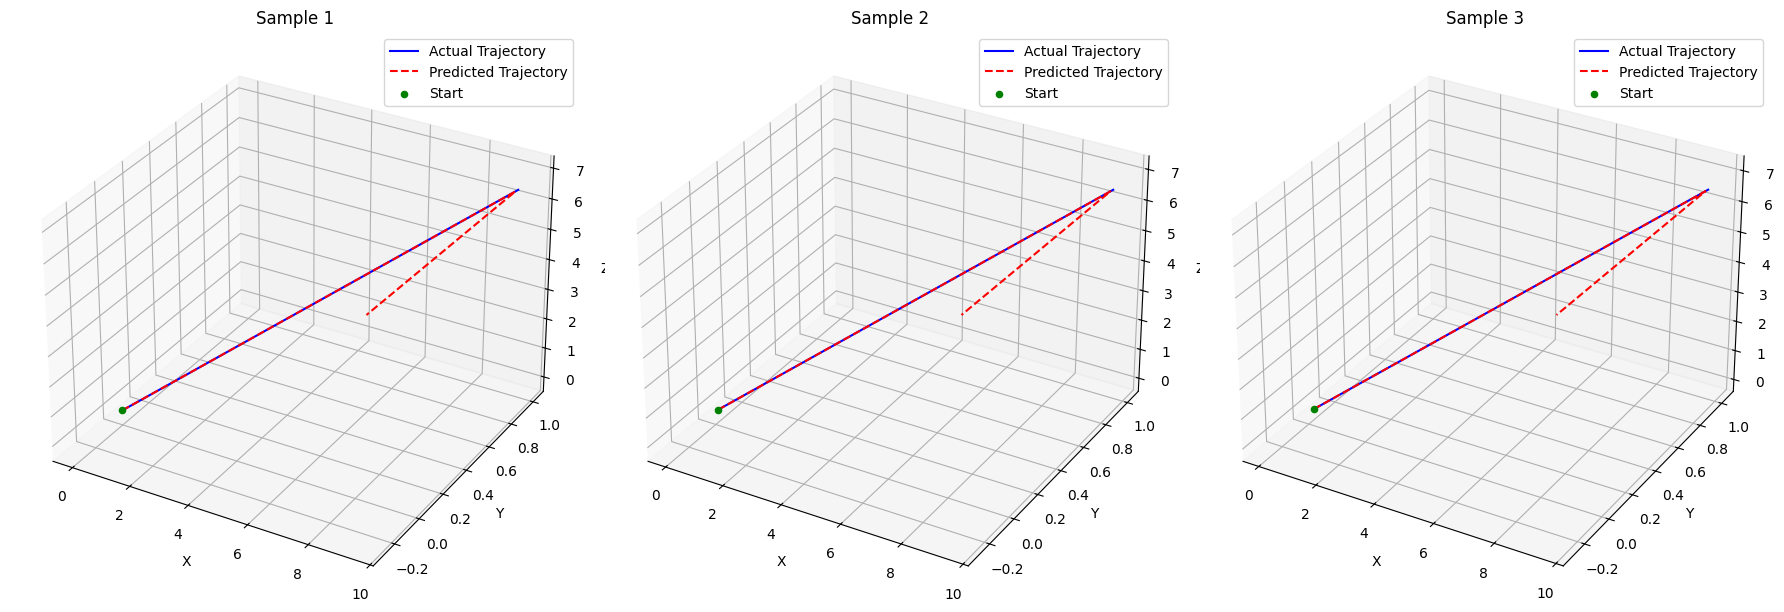

In [ ]:
# Generate synthetic data
def generate_trajectory_data(bias_value, num_samples, num_time_steps, dt=0.01):
    """
    Generate synthetic trajectory data for Tetris objects.

    Args:
        num_samples: Number of samples (trajectories) to generate.
        num_time_steps: Number of time steps in each trajectory.
        dt: Time interval between steps.

    Returns:
        positions: Tensor of shape (num_samples, num_time_steps, 3)
                   containing positions at each time step.
    """
    # Random initial positions and velocities
    initial_positions = torch.rand(num_samples, 3) * 10  # Positions between 0 and 10

    # For simplicity, assume constant velocity (no acceleration)
    positions = []
    for t in range(num_time_steps):
        positions_t = initial_positions * (t * dt)
        if bias_value != 0:
            noise = torch.normal(mean=0.0, std=1e-3, size=positions_t.shape)
            positions_t = torch.where(torch.abs(positions_t - bias_value) < 1e-6, positions_t + noise, positions_t)
        positions.append(positions_t)
    positions = torch.stack(positions, dim=1)  # Shape: (num_samples, num_time_steps, 3)

    return positions

# Create a Dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, positions, input_seq_len=145, pred_seq_len=1, dt = 0.01):
        self.positions = positions
        self.num_samples = positions.shape[0]
        self.num_time_steps = positions.shape[1]
        self.input_seq_len = input_seq_len
        self.pred_seq_len = pred_seq_len
        self.dt = dt

    def __len__(self):
        return self.num_samples * (self.num_time_steps - self.input_seq_len - self.pred_seq_len)

    def __getitem__(self, idx):
        sample_idx = idx // (self.num_time_steps - self.input_seq_len - self.pred_seq_len)
        time_idx = idx % (self.num_time_steps - self.input_seq_len - self.pred_seq_len)
        input_position = self.positions[sample_idx, time_idx:time_idx + self.input_seq_len]  # Input sequence

        start_idx = time_idx + self.input_seq_len
        end_idx = min(start_idx + self.pred_seq_len, self.positions.shape[1]) #relative to last pos.
        assert end_idx <= self.positions.shape[1]
        target_position = self.positions[sample_idx, start_idx:end_idx]

        return input_position, target_position

def loss_fx(predicted, target):
    huber_loss = nn.HuberLoss()(predicted, target)  # Regular position loss
    diff = predicted - target
    geo_loss = torch.acos(torch.clamp(1 - torch.norm(diff, dim=-1), -1, 1)).mean() #Orientation Aware
    return huber_loss + 0.1 * geo_loss

num_samples = 50
num_time_steps = 200
bias_value = 0.1

model = GCA_MLP()
model = model.to(model.device)

# Generate data
positions = generate_trajectory_data(bias_value, num_samples, num_time_steps)

# Split data into training and testing sets
train_ratio = 0.9
num_train = int(num_samples * train_ratio)
train_positions = positions[:num_train]
test_positions = positions[num_train:]

# Create DataLoaders
batch_size = 5
train_dataset = TrajectoryDataset(train_positions)
print("Train dataset length:", len(train_dataset))
test_dataset = TrajectoryDataset(test_positions)
print("Test dataset length:", len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loss function and optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=2e-3, weight_decay=1e-5)

# Training loop
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (input_position, target_position) in enumerate(train_loader):
        input_position = input_position.to(model.device)
        target_position = target_position.to(model.device)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Forward pass
        output = model(input_position)
        loss = loss_fx(output, target_position)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch % 10 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Testing loop
model.eval()
all_inputs = []
all_targets = []
all_predictions = []
with torch.no_grad():
    total_loss = 0
    for input_position, target_position in test_loader:
        input_position = input_position.to(model.device)
        target_position = target_position.to(model.device)

        # Forward pass
        output = model(input_position)

        # Compute loss
        loss = loss_fx(output, target_position)
        total_loss += loss.item()

        all_inputs.append(input_position.cpu())
        all_targets.append(target_position.cpu())
        all_predictions.append(output.cpu())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")

all_inputs = torch.cat(all_inputs, dim=0)
all_targets = torch.cat(all_targets, dim=0)
all_predictions = torch.cat(all_predictions, dim=0)

num_plot_samples = 3  # Number of samples to plot
fig = plt.figure(figsize=(18, 6))

for i in range(num_plot_samples):
    # Get input and target positions for sample i
    input_position = all_inputs[i].numpy()  # Shape: [input_seq_len, 3]
    target_position = all_targets[i].numpy()  # Shape: [pred_seq_len, 3]
    prediction = all_predictions[i].numpy()  # Shape: [pred_seq_len, 3]

    # Concatenate input and target positions
    full_target_pos = np.concatenate([input_position, target_position], axis=0)
    full_pred_pos = np.concatenate([input_position, prediction], axis=0)

    ax = fig.add_subplot(1, num_plot_samples, i + 1, projection='3d')
    ax.plot(full_target_pos[:, 0], full_target_pos[:, 1], full_target_pos[:, 2], 'b-', label='Actual Trajectory')
    ax.plot(full_pred_pos[:, 0], full_pred_pos[:, 1], full_pred_pos[:, 2], 'r--', label='Predicted Trajectory')
    ax.scatter(input_position[0, 0], input_position[0, 1], input_position[0, 2], c='g', marker='o', label='Start')
    ax.legend()
    ax.set_title(f"Sample {i+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
plt.tight_layout()
plt.show()